In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl

from scipy.signal import decimate

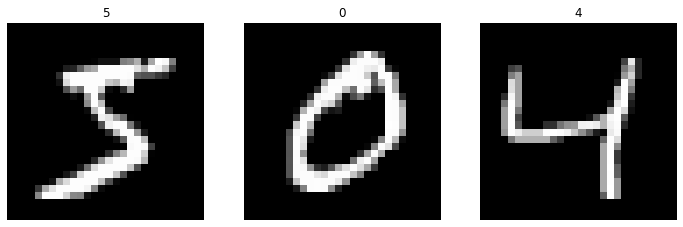

In [2]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

q = 2

# train_images = decimate(decimate(train_images, q, axis=2), q, axis=1)
# test_images = decimate(decimate(test_images, q, axis=2), q, axis=1)

N = train_images.shape[1]

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))




plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (N, N)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))

In [3]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=16, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 16)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [4]:
minibatch_size = 25
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [5]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))


In [6]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)


Accuracy before training: 0.06679999828338623:00:00                            


In [7]:
do_training = True
if do_training:
    # run training
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_images, {out_p: train_labels}, epochs=10)

    # save the parameters to file
    sim.save_params("./mnist_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1l5aivQljFoXzPP5JVccdFXbOYRv3BCJR",
        "mnist_params.npz",
    )

    # load parameters
    sim.load_params("./mnist_params")


Epoch 1/10
2400/2400 [==============================] - 22s 8ms/step - loss: 0.1919 - out_p_loss: 0.1919
Epoch 2/10
2400/2400 [==============================] - 19s 8ms/step - loss: 0.0720 - out_p_loss: 0.0720
Epoch 3/10
2400/2400 [==============================] - 19s 8ms/step - loss: 0.0598 - out_p_loss: 0.0598
Epoch 4/10
2400/2400 [==============================] - 19s 8ms/step - loss: 0.0534 - out_p_loss: 0.0534
Epoch 5/10
2400/2400 [==============================] - 18s 7ms/step - loss: 0.0507 - out_p_loss: 0.0507
Epoch 6/10
2400/2400 [==============================] - 17s 7ms/step - loss: 0.0474 - out_p_loss: 0.0474
Epoch 7/10
2400/2400 [==============================] - 19s 8ms/step - loss: 0.0453 - out_p_loss: 0.0453
Epoch 8/10
2400/2400 [==============================] - 19s 8ms/step - loss: 0.0436 - out_p_loss: 0.0436
Epoch 9/10
2400/2400 [==============================] - 18s 7ms/step - loss: 0.0439 - out_p_loss: 0.0439
Epoch 10/10
2400/2400 [==============================] 

In [8]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)


Accuracy after training: 0.9107000231742859 0:00:00                            


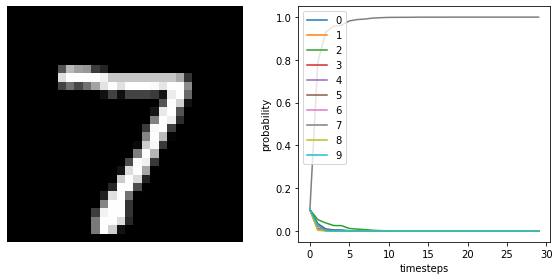

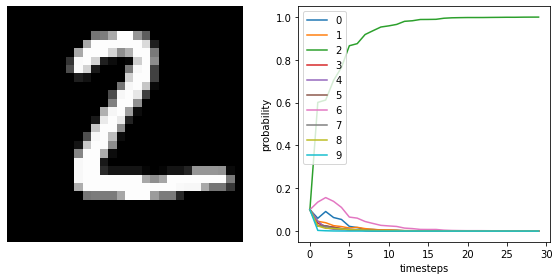

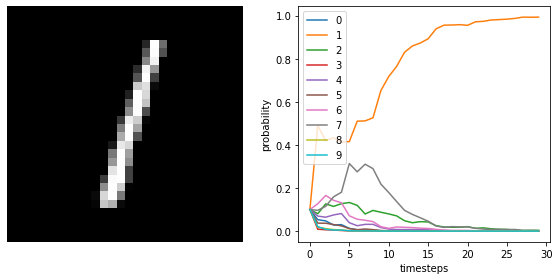

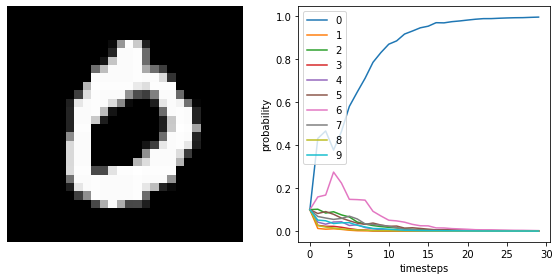

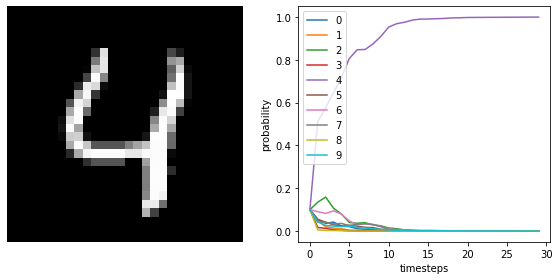

In [9]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [10]:
sim.close()

In [1]:
train_images.shape

NameError: name 'train_images' is not defined